# imports

In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

# supress the warnings
import warnings

warnings.filterwarnings("ignore")
# supress ConvergenceWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action="ignore", category=ConvergenceWarning)

In [2]:
if os.environ.get("KAGGLE_KERNEL_RUN_TYPE", ""):
    train_df_ = pd.read_csv(
        "/kaggle/input/icr-identify-age-related-conditions/train.csv"
    )
    test_df_ = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")
else:
    train_df_ = pd.read_csv("data/train.csv")
    test_df_ = pd.read_csv("data/test.csv")

# Preprocess

In [3]:
y_train = train_df_["Class"]
train_df = train_df_.drop("Class", axis=1)

ids = test_df_["Id"]
train_df.drop("Id", axis=1, inplace=True)
test_df = test_df_.drop("Id", axis=1)

In [4]:
# do one-hot encoding to EJ column

train_df["EJ"] = train_df["EJ"].apply(lambda x: 1 if x == "Yes" else 0)
test_df["EJ"] = test_df["EJ"].apply(lambda x: 1 if x == "Yes" else 0)

In [5]:
# Fill missing values with median if less than 3 values are missing else impute with KNN imputer

col_fill_na_median = []
col_fill_na_knn = []

for col in train_df.columns:
    if train_df[col].isnull().sum() > 2:
        col_fill_na_knn.append(col)
    elif train_df[col].isnull().sum() > 0:
        col_fill_na_median.append(col)

for col in test_df.columns:
    if test_df[col].isnull().sum() > 2:
        col_fill_na_knn.append(col)
    elif test_df[col].isnull().sum() > 0:
        col_fill_na_median.append(col)

print("Columns to fill with median: ", col_fill_na_median)
print("Columns to fill with KNN: ", col_fill_na_knn)

Columns to fill with median:  ['CB', 'DU', 'FC', 'FL', 'FS', 'GL']
Columns to fill with KNN:  ['BQ', 'CC', 'EL']


In [6]:
# fill missing values with mdeian

transformers_1 = []
transformers_1.append(
    (
        "median_imputer",
        SimpleImputer(
            strategy="median",
        ),
        col_fill_na_median,
    )
)

# fill missing values with KNN

transformers_1.append(
    (
        "knn_imputer",
        KNNImputer(
            n_neighbors=5,
        ),
        col_fill_na_knn,
    )
)

print(transformers_1)

preprocessor = ColumnTransformer(transformers=transformers_1, remainder="passthrough")

scaler = StandardScaler()


pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("scaler", scaler)])
pipeline

[('median_imputer', SimpleImputer(strategy='median'), ['CB', 'DU', 'FC', 'FL', 'FS', 'GL']), ('knn_imputer', KNNImputer(), ['BQ', 'CC', 'EL'])]


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('median_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  ['CB', 'DU', 'FC', 'FL', 'FS',
                                                   'GL']),
                                                 ('knn_imputer', KNNImputer(),
                                                  ['BQ', 'CC', 'EL'])])),
                ('scaler', StandardScaler())])

In [7]:
train_data = pipeline.fit_transform(train_df)
test_data = pipeline.transform(test_df)

# Training

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# from scipy.stats import uniform
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

## Train-test split

In [9]:
train_X, test_X, train_Y, test_Y = train_test_split(
    train_data, y_train, test_size=0.2, random_state=42
)

## Helper functions

In [10]:
def balanced_log_loss(y_true, y_pred):
    #     y_pred = estimator.predict_proba(X)
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)

    # calculate the weights for each class
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    epsilon = 1e-10
    # calculate the predicted probabilities for each class
    p = np.clip(y_pred, 1e-15, 1 - 1e-15)
    #     p_1 = np.clip(y_pred[:, 1], 1e-15, 1 - 1e-15)
    # calculate the log loss for each class
    log_loss_0 = -w_0 * np.sum(y_true * np.log(1 - p + epsilon))
    log_loss_1 = -w_1 * np.sum(y_true * np.log(p))

    # calculate the balanced logarithmic loss
    balanced_log_loss = (log_loss_0 + log_loss_1) / 2

    return balanced_log_loss


custom_scoring = make_scorer(
    balanced_log_loss, greater_is_better=False, needs_proba=True
)


# custom scoring function
# def custom_scorer(y_true, y_pred):
#     # balanced log loss
#     N_0 = np.sum(y_true == 0)
#     N_1 = np.sum(y_true == 1)

#     y_pred =  np.clip(y_pred, 1e-15, 1 - 1e-15)

#     log_loss_0 = np.sum(y_true[y_true == 0] * np.log(y_pred[y_true == 0]))

#     log_loss_1 = np.sum(y_true[y_true == 1] * np.log(y_pred[y_true == 1]))

#     return -(log_loss_0 / N_0 + log_loss_1 / N_1) / 2

# custom_scoring = make_scorer(custom_scorer, greater_is_better=False)

In [11]:
def train_model(X_train, y_train, X_test, y_test, model):
    """
    This function trains a model and prints the accuracy score for both the train and test sets
    """
    model.fit(X_train, y_train)
    #     print('Train accuracy score: ', model.score(X_train, y_train))
    #     print('Test accuracy score: ', model.score(X_test, y_test))
    print("Train Balanced Logarithmic Loss: ", -custom_scoring(model, X_train, y_train))
    print("Test Balanced Logarithmic Loss: ", -custom_scoring(model, X_test, y_test))


def grid_search(X_train, y_train, model, param_grid, cv=5, scoring=None):
    """
    This function performs grid search on the given model and prints the best parameters
    """
    grid = GridSearchCV(
        model, param_grid, cv=cv, verbose=1, scoring=scoring, refit=True, n_jobs=-1
    )
    grid.fit(X_train, y_train)
    print("Best parameters: ", grid.best_params_)
    #     print('Best score: ', grid.best_score_)
    model = grid
    print("Train Balanced Logarithmic Loss: ", -custom_scoring(model, X_train, y_train))
    print("Test Balanced Logarithmic Loss: ", -custom_scoring(model, test_X, test_Y))
    return grid.best_params_, model


def plot_confusion_matrix(X_train, y_train, X_test, y_test, model):
    """
    This function plots the confusion matrix for both the train and test sets
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.heatmap(
        confusion_matrix(y_train, model.predict(X_train)), annot=True, fmt="d", ax=ax[0]
    )
    ax[0].set_title("Train Confusion Matrix")
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")
    sns.heatmap(
        confusion_matrix(y_test, model.predict(X_test)), annot=True, fmt="d", ax=ax[1]
    )
    ax[1].set_title("Test Confusion Matrix")
    ax[1].set_xlabel("Predicted Label")
    ax[1].set_ylabel("True Label")
    plt.tight_layout()


# display classification report
def classification_report_df(model):
    """
    This function prints the classification report for both the train and test sets
    """
    print("Train Classification Report")
    print(classification_report(train_Y, model.predict(train_X)))
    print("Test Classification Report")
    print(classification_report(test_Y, model.predict(test_X)))

## Logistic Regression

In [12]:
# create the LogisticRegression object, giving the class_weight parameter
lg = LogisticRegression(class_weight="balanced")

# train the model
train_model(train_X, train_Y, test_X, test_Y, lg)

Train Balanced Logarithmic Loss:  0.5753806167407706
Test Balanced Logarithmic Loss:  0.5377045389944048


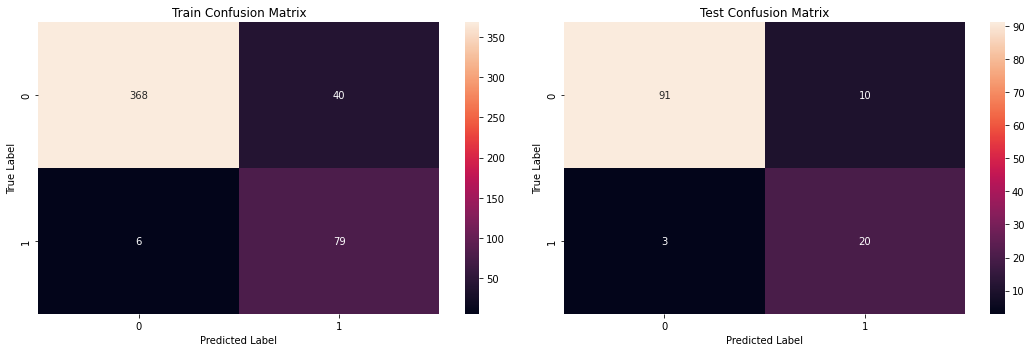

In [13]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, lg)

In [14]:
classification_report_df(lg)

Train Classification Report
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       408
           1       0.66      0.93      0.77        85

    accuracy                           0.91       493
   macro avg       0.82      0.92      0.86       493
weighted avg       0.93      0.91      0.91       493

Test Classification Report
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       101
           1       0.67      0.87      0.75        23

    accuracy                           0.90       124
   macro avg       0.82      0.89      0.84       124
weighted avg       0.91      0.90      0.90       124



- let's try to tune some hyperparameters to see if we can get better results.

In [16]:
lg.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [18]:
# create the LogisticRegression object, giving the class_weight parameter
grid_lg = LogisticRegression(class_weight="balanced", n_jobs=-1)

distribs = {
    "penalty": ["l1", "l2"],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "max_iter": [5500],
    "solver": ["saga", "lbfgs"],
}

# train the model
best_params, grid_lg = grid_search(
    train_X, train_Y, grid_lg, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters:  {'C': 0.01, 'max_iter': 5500, 'penalty': 'l2', 'solver': 'saga'}
Train Balanced Logarithmic Loss:  0.37019324250996155
Test Balanced Logarithmic Loss:  0.39567243750514897


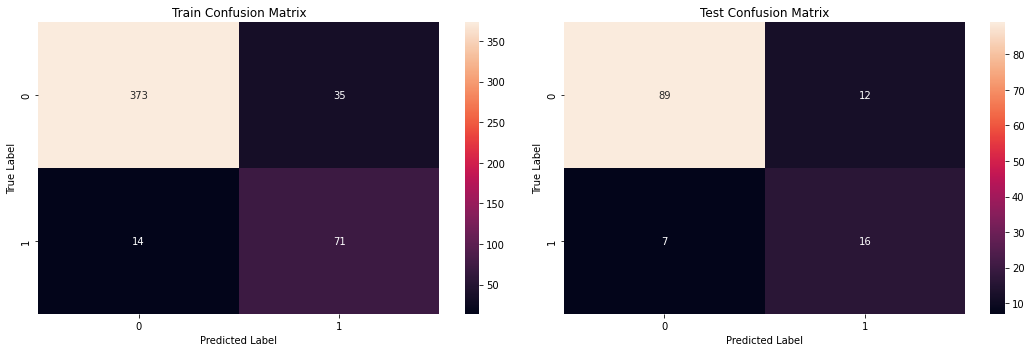

In [19]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, grid_lg)

In [20]:
classification_report_df(grid_lg)

Train Classification Report
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       408
           1       0.67      0.84      0.74        85

    accuracy                           0.90       493
   macro avg       0.82      0.87      0.84       493
weighted avg       0.91      0.90      0.90       493

Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       101
           1       0.57      0.70      0.63        23

    accuracy                           0.85       124
   macro avg       0.75      0.79      0.77       124
weighted avg       0.86      0.85      0.85       124



## SVM

### Kernel `rbf`

In [21]:
svm_rbf = SVC(kernel="rbf", class_weight="balanced", probability=True)

# train the model
train_model(train_X, train_Y, test_X, test_Y, svm_rbf)

Train Balanced Logarithmic Loss:  0.3409893246133263
Test Balanced Logarithmic Loss:  0.4896452889747938


### Kernel `linear`

In [22]:
svm_linear = SVC(kernel="linear", class_weight="balanced", probability=True)

# train the model
train_model(train_X, train_Y, test_X, test_Y, svm_linear)

Train Balanced Logarithmic Loss:  0.5949490299140754
Test Balanced Logarithmic Loss:  0.5812261473877688


- `linear` kernel is performing worse than `rbf` kernel.

### Kernel `poly`

In [23]:
svm_poly = SVC(kernel="poly", class_weight="balanced", probability=True)

# train the model
train_model(train_X, train_Y, test_X, test_Y, svm_poly)

Train Balanced Logarithmic Loss:  0.8557450734421309
Test Balanced Logarithmic Loss:  0.899086657547087


- more worst than `linear` kernel.

- So we will do a hyperparameter tuning for `rbf` and `linear` kernels. and `poly` kernel with different degrees.

In [25]:
svm_rbf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [30]:
grid_svm = SVC(class_weight="balanced", probability=True)

distribs = {
    "kernel": ["rbf", "linear", "poly"],
    "C": [0.001, 0.01, 0.1, 1],
    "degree": [2, 3, 4, 5],
    "gamma": ["scale", "auto"],
    "shrinking": [True, False],
}

# train the model
best_params, grid_svm = grid_search(
    train_X, train_Y, grid_svm, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters:  {'C': 1, 'degree': 5, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True}
Train Balanced Logarithmic Loss:  0.352242936050685
Test Balanced Logarithmic Loss:  0.4895507147038982


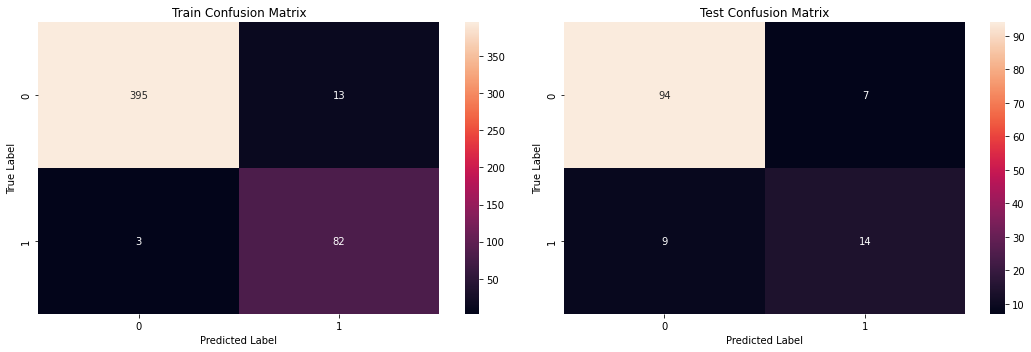

In [31]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, grid_svm)

In [32]:
classification_report_df(grid_svm)

Train Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       408
           1       0.86      0.96      0.91        85

    accuracy                           0.97       493
   macro avg       0.93      0.97      0.95       493
weighted avg       0.97      0.97      0.97       493

Test Classification Report
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       101
           1       0.67      0.61      0.64        23

    accuracy                           0.87       124
   macro avg       0.79      0.77      0.78       124
weighted avg       0.87      0.87      0.87       124



- let's try to find the best hyperparameters for `rbf` kernel.

In [34]:
grid_svm2 = SVC(class_weight="balanced", probability=True)


distribs = {
    "kernel": ["rbf"],
    "C": [0.8, 1, 2],
    "gamma": ["auto"],
    "shrinking": [True],
}

# train the model
best_params, grid_svm2 = grid_search(
    train_X, train_Y, grid_svm2, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters:  {'C': 2, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True}
Train Balanced Logarithmic Loss:  0.3376289288338511
Test Balanced Logarithmic Loss:  0.5038285604630192


- Almost same results as before. So we will stop here.

In [35]:
best_params

{'C': 2, 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True}

## Decision Tree

In [36]:
# create the DecisionTreeClassifier object, giving the class_weight parameter
dt = DecisionTreeClassifier(class_weight="balanced")

# train the model
train_model(train_X, train_Y, test_X, test_Y, dt)

Train Balanced Logarithmic Loss:  2.398525097706579
Test Balanced Logarithmic Loss:  6.442876087398512


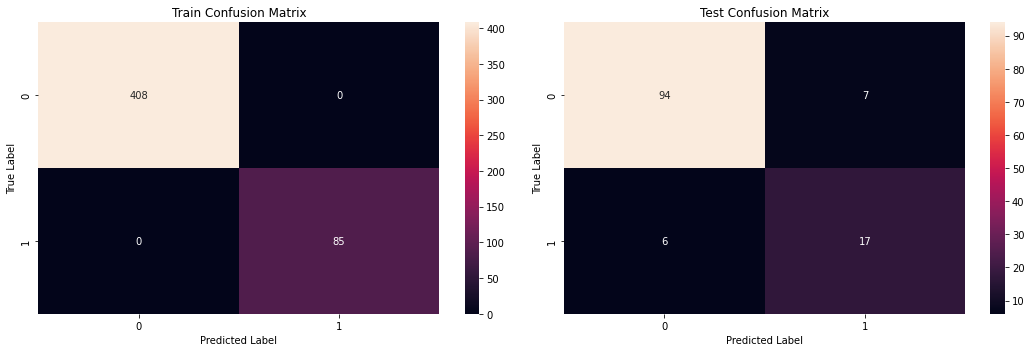

In [37]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, dt)

- It is clearlly overfitting.

In [48]:
grid_dt1 = DecisionTreeClassifier(class_weight="balanced")

distribs = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [None, 2, 6, 7, 10],
    "min_samples_split": [2, 6, 10],
    "min_samples_leaf": [1, 6, 10],
    "max_features": ["sqrt", "log2"],
}

# train the model
best_params1, grid_dt1 = grid_search(
    train_X, train_Y, grid_dt1, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best parameters:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'splitter': 'random'}
Train Balanced Logarithmic Loss:  0.4187764215674655
Test Balanced Logarithmic Loss:  0.42549628903382636


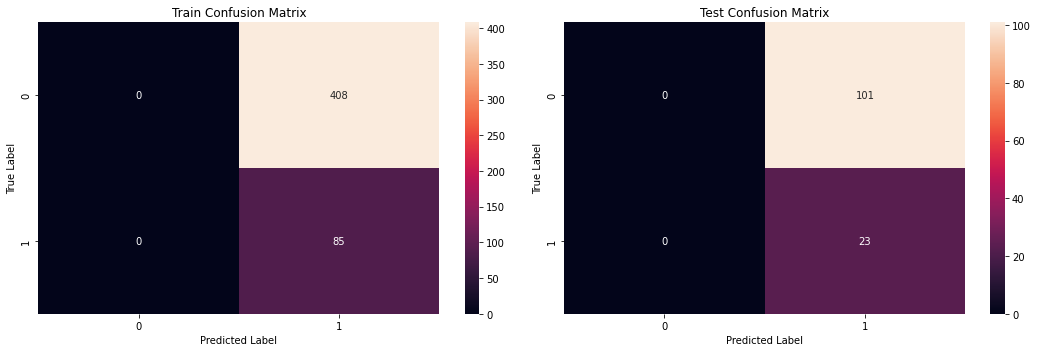

In [49]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, grid_dt1)

In [50]:
classification_report_df(grid_dt1)

Train Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       408
           1       0.17      1.00      0.29        85

    accuracy                           0.17       493
   macro avg       0.09      0.50      0.15       493
weighted avg       0.03      0.17      0.05       493

Test Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.19      1.00      0.31        23

    accuracy                           0.19       124
   macro avg       0.09      0.50      0.16       124
weighted avg       0.03      0.19      0.06       124



### Random Forest

In [51]:
# create the RandomForestClassifier object, giving the class_weight parameter
rf = RandomForestClassifier(
    class_weight="balanced",
    max_depth=5,
    n_estimators=100,
    min_samples_split=4,
    min_samples_leaf=1,
)


# train the model
train_model(train_X, train_Y, test_X, test_Y, rf)

Train Balanced Logarithmic Loss:  0.30164975124890747
Test Balanced Logarithmic Loss:  0.4079521282818487


- This is performing better, let's do a Grid Search to hypertune

In [52]:
grid_rf = RandomForestClassifier(class_weight="balanced")

distribs = {
    "n_estimators": [100, 200, 300, 400, 500],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 2, 7, 14],
    "min_samples_split": [2, 7, 14],
    "min_samples_leaf": [1, 7, 14],
}

# train the model
best_params, grid_rf = grid_search(
    train_X, train_Y, grid_rf, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best parameters:  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 14, 'min_samples_split': 14, 'n_estimators': 400}
Train Balanced Logarithmic Loss:  0.30680929826544745
Test Balanced Logarithmic Loss:  0.3516117627430212


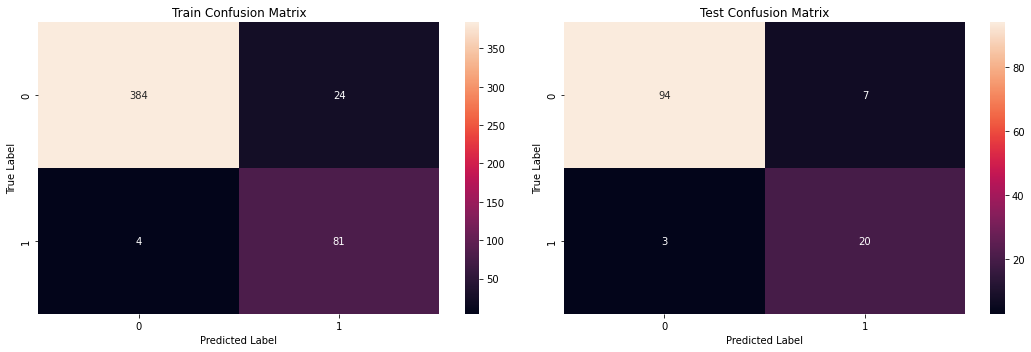

In [53]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, grid_rf)

In [54]:
classification_report_df(grid_rf)

Train Classification Report
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       408
           1       0.77      0.95      0.85        85

    accuracy                           0.94       493
   macro avg       0.88      0.95      0.91       493
weighted avg       0.95      0.94      0.95       493

Test Classification Report
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       101
           1       0.74      0.87      0.80        23

    accuracy                           0.92       124
   macro avg       0.85      0.90      0.87       124
weighted avg       0.93      0.92      0.92       124



- Better results than before. Let's try to find the best hyperparameter in smaller range.

In [55]:
best_params

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 14,
 'min_samples_split': 14,
 'n_estimators': 400}

In [56]:
grid_rf2 = RandomForestClassifier(class_weight="balanced")

distribs = {
    "n_estimators": [350, 400, 450],
    "criterion": ["gini"],
    "max_depth": [15, 20, 30],
    "min_samples_split": [12, 14, 16],
    "min_samples_leaf": [13, 14, 15],
}

# train the model
best_params, grid_rf2 = grid_search(
    train_X, train_Y, grid_rf2, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


Best parameters:  {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 14, 'min_samples_split': 12, 'n_estimators': 400}
Train Balanced Logarithmic Loss:  0.3068962399000057
Test Balanced Logarithmic Loss:  0.3495173200438142


In [57]:
best_params

{'criterion': 'gini',
 'max_depth': 30,
 'min_samples_leaf': 14,
 'min_samples_split': 12,
 'n_estimators': 400}

- Not much improvement. So we will stop here.

## XGBoost

In [100]:
# create the XGBClassifier object, giving the class_weight parameter
xgb = XGBClassifier(
    scale_pos_weight=7,
    max_depth=3,
    n_estimators=4,
    min_child_weight=15,
)

# train the model
train_model(train_X, train_Y, test_X, test_Y, xgb)

Train Balanced Logarithmic Loss:  0.2973549237803501
Test Balanced Logarithmic Loss:  0.3184544741209344


In [101]:
xgb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': 15,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 4,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 7,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

- Let's tune the hyperparameters

In [107]:
grid_xgb = XGBClassifier(scale_pos_weight=7)

distribs = {
    "max_depth": [1, 2, 3, 5, 7],
    "n_estimators": [3, 4, 5, 6, 10, 15],
    "min_child_weight": [1, 7, 15],
    "gamma": [0.0, 0.1, 0.4],
    "subsample": [0.5, 0.8, 0.9],
    "colsample_bytree": [0.1, 0.5, 0.9],
    "learning_rate": [0.01, 0.05],
}

# train the model
best_params, grid_xgb = grid_search(
    train_X, train_Y, grid_xgb, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 4860 candidates, totalling 24300 fits
Best parameters:  {'colsample_bytree': 0.9, 'gamma': 0.4, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 15, 'n_estimators': 15, 'subsample': 0.8}
Train Balanced Logarithmic Loss:  0.3194817977208717
Test Balanced Logarithmic Loss:  0.34243380351796315


- Let's try to regularize it somewhat

In [108]:
grid_xgb = XGBClassifier(scale_pos_weight=7)

distribs = {
    "max_depth": [3, 4],
    "n_estimators": [14, 15, 20],
    "min_child_weight": [14, 15, 16],
    "gamma": [0.3, 0.4, 0.5],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.8, 0.9, 0.99],
    "learning_rate": [0.05],
}

# train the model
best_params, grid_xgb = grid_search(
    train_X, train_Y, grid_xgb, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 15, 'n_estimators': 20, 'subsample': 0.7}
Train Balanced Logarithmic Loss:  0.30913961150628677
Test Balanced Logarithmic Loss:  0.33757504892025947


- Base XGBClassifier is performing better than the tuned one. So we will stop here.

## CatBoost

In [109]:
# create the CatBoostClassifier object, giving the class_weight parameter
cat = CatBoostClassifier(class_weights=[1, 7], max_depth=3, n_estimators=40)

# train the model
train_model(train_X, train_Y, test_X, test_Y, cat)

Learning rate set to 0.145778
0:	learn: 0.6431852	total: 50.2ms	remaining: 1.96s
1:	learn: 0.5698624	total: 51.2ms	remaining: 974ms
2:	learn: 0.5208585	total: 52.6ms	remaining: 649ms
3:	learn: 0.4877621	total: 53.5ms	remaining: 481ms
4:	learn: 0.4718369	total: 54.4ms	remaining: 381ms
5:	learn: 0.4560193	total: 55.5ms	remaining: 314ms
6:	learn: 0.4362693	total: 56.4ms	remaining: 266ms
7:	learn: 0.4048656	total: 57.1ms	remaining: 228ms
8:	learn: 0.3870752	total: 57.9ms	remaining: 200ms
9:	learn: 0.3712172	total: 58.9ms	remaining: 177ms
10:	learn: 0.3615044	total: 59.9ms	remaining: 158ms
11:	learn: 0.3462753	total: 60.6ms	remaining: 141ms
12:	learn: 0.3325243	total: 61.4ms	remaining: 128ms
13:	learn: 0.3239236	total: 62.3ms	remaining: 116ms
14:	learn: 0.3111328	total: 63ms	remaining: 105ms
15:	learn: 0.3029537	total: 63.8ms	remaining: 95.7ms
16:	learn: 0.2977770	total: 64.5ms	remaining: 87.3ms
17:	learn: 0.2869054	total: 65.4ms	remaining: 79.9ms
18:	learn: 0.2783248	total: 66.2ms	remainin

- Let's tune the hyperparameters

In [110]:
cat.get_params()

{'class_weights': [1, 7], 'max_depth': 3, 'n_estimators': 40}

In [111]:
grid_cat = CatBoostClassifier(class_weights=[1, 7])

distribs = {
    "max_depth": [3, 4, 5],
    "n_estimators": [40, 50, 60],
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5],
}

# train the model
best_params, grid_cat = grid_search(
    train_X, train_Y, grid_cat, distribs, cv=5, scoring=custom_scoring
)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
0:	learn: 0.6889022	total: 52.8ms	remaining: 2.58s
0:	learn: 0.6888730	total: 53.2ms	remaining: 2.07s
0:	learn: 0.6889022	total: 53ms	remaining: 3.13s
0:	learn: 0.6878730
0:	learn: 0.6887859	total: 51.4ms	remaining: 2.52s
0:	learn: 0.6888730	total: 55.1ms	remaining: 2.7s
1:	learn: 0.6851260	total: 56.9ms	remaining: 1.37s
1:	learn: 0.6869275	total: 56.3ms	remaining: 1.63s
0:	learn: 0.6878730	total: 53.8ms	remaining: 2.1s
0:	learn: 0.6887859	total: 361ms	remaining: 14.1s
2:	learn: 0.6826869	total: 59.2ms	remaining: 1.12s
1:	learn: 0.6835197	total: 57.7ms	remaining: 1.38s
1:	learn: 0.6869275	total: 62.8ms	remaining: 1.51s
0:	learn: 0.6889022	total: 70.6ms	remaining: 2.75s
2:	learn: 0.6826869	total: 74.6ms	remaining: 1.17s
3:	learn: 0.6771193	total: 76.3ms	remaining: 878ms
4:	learn: 0.6724919	total: 78.3ms	remaining: 705ms
2:	learn: 0.6783727	total: 81.1ms	remaining: 1.27s
5:	learn: 0.6681806	total: 80.8ms	remaining: 592ms
0:	le

## Let's try to make the Ensemble

- Weights to each model will be given according to their performance on the test data.

In [113]:
# create the EnsembleVoteClassifier object, giving the class_weight parameter
dtc = DecisionTreeClassifier(
    class_weight="balanced",
    criterion="gini",
    max_depth=2,
    max_features="log2",
    min_samples_leaf=10,
    min_samples_split=10,
    splitter="random",
)

rf = RandomForestClassifier(
    class_weight="balanced",
    criterion="gini",
    max_depth=30,
    min_samples_leaf=14,
    min_samples_split=12,
    n_estimators=400,
)

xgb = XGBClassifier(
    scale_pos_weight=7,
    max_depth=3,
    n_estimators=4,
    min_child_weight=15,
)

cat = CatBoostClassifier(
    class_weights=[1, 7],
    l2_leaf_reg=5,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=40,
)


vc = VotingClassifier(
    estimators=[
        ("xgb", xgb),
        ("rf", rf),
        ("cat", cat),
        ("dtc", dtc),
    ],
    voting="soft",
    weights=[3, 2, 2.2, 1],
)

# train the model
train_model(train_X, train_Y, test_X, test_Y, vc)

0:	learn: 0.6750499	total: 1.2ms	remaining: 47ms
1:	learn: 0.6456159	total: 2.36ms	remaining: 44.8ms
2:	learn: 0.6222568	total: 3.31ms	remaining: 40.8ms
3:	learn: 0.6044121	total: 4.2ms	remaining: 37.8ms
4:	learn: 0.5937887	total: 5.13ms	remaining: 35.9ms
5:	learn: 0.5806009	total: 6.04ms	remaining: 34.2ms
6:	learn: 0.5605590	total: 6.89ms	remaining: 32.5ms
7:	learn: 0.5395471	total: 7.73ms	remaining: 30.9ms
8:	learn: 0.5281598	total: 8.64ms	remaining: 29.8ms
9:	learn: 0.5168188	total: 9.62ms	remaining: 28.8ms
10:	learn: 0.5043025	total: 10.6ms	remaining: 28ms
11:	learn: 0.4953124	total: 11.7ms	remaining: 27.2ms
12:	learn: 0.4783019	total: 12.7ms	remaining: 26.3ms
13:	learn: 0.4665832	total: 13.7ms	remaining: 25.4ms
14:	learn: 0.4603620	total: 14.6ms	remaining: 24.3ms
15:	learn: 0.4535449	total: 15.4ms	remaining: 23ms
16:	learn: 0.4478525	total: 16.1ms	remaining: 21.8ms
17:	learn: 0.4310826	total: 16.9ms	remaining: 20.7ms
18:	learn: 0.4223115	total: 17.7ms	remaining: 19.6ms
19:	learn: 

In [118]:
# Training the VC on whole dataset and predicting on test dataset
vc_final = VotingClassifier(
    estimators=[
        ("xgb", xgb),
        ("rf", rf),
        ("cat", cat),
        ("dtc", dtc),
    ],
    voting="soft",
    weights=[3, 2, 2.2, 1],
)
vc_final.fit(train_data, y_train)

0:	learn: 0.6648973	total: 1.08ms	remaining: 42.3ms
1:	learn: 0.6384891	total: 2.29ms	remaining: 43.4ms
2:	learn: 0.6078403	total: 3.38ms	remaining: 41.7ms
3:	learn: 0.5884462	total: 4.39ms	remaining: 39.6ms
4:	learn: 0.5767551	total: 5.4ms	remaining: 37.8ms
5:	learn: 0.5614939	total: 6.34ms	remaining: 35.9ms
6:	learn: 0.5492553	total: 7.5ms	remaining: 35.4ms
7:	learn: 0.5305940	total: 8.68ms	remaining: 34.7ms
8:	learn: 0.5150730	total: 9.73ms	remaining: 33.5ms
9:	learn: 0.4973311	total: 10.8ms	remaining: 32.4ms
10:	learn: 0.4903339	total: 11.9ms	remaining: 31.3ms
11:	learn: 0.4796630	total: 12.8ms	remaining: 30ms
12:	learn: 0.4651282	total: 13.7ms	remaining: 28.5ms
13:	learn: 0.4561764	total: 14.7ms	remaining: 27.3ms
14:	learn: 0.4439210	total: 15.7ms	remaining: 26.2ms
15:	learn: 0.4342201	total: 16.7ms	remaining: 25ms
16:	learn: 0.4285481	total: 17.9ms	remaining: 24.2ms
17:	learn: 0.4194253	total: 18.9ms	remaining: 23.1ms
18:	learn: 0.4114468	total: 19.9ms	remaining: 22ms
19:	learn: 

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=30,
                                                     min_samples_leaf=14,
                                                     min_samples_split=12,
                                                     n_estimators=400)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7f8f811afac0>),
                             ('dtc',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=2,
                                                     max_features='log2',
                                                     min_samples_leaf=10,
                                                     min_samples_split=10,
                                                     splitter='random'))],
                 voting='soft', weights=[3, 2, 2.2, 1])

# Predictions

In [122]:
# Predicting on test dataset
y_pred = vc_final.predict_proba(test_data)

In [ ]:
# y_pred[:, 1] = np.maximum(np.minimum(y_pred[:, 1], 1-1e-15), 1e-15)
# y_pred[:, 0] = np.maximum(np.minimum(y_pred[:, 0], 1-1e-15), 1e-15)

In [2]:
# import pandas as pd
# y_pred = pd.read_csv("submission.csv")

# y_pred

In [123]:
submission = pd.DataFrame({"Id": ids, "class_0": y_pred[:, 0], "class_1": y_pred[:, 1]})

In [124]:
submission.to_csv("submission.csv", index=False)